In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import os 
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
# Ionpy imports
from ionpy.analysis import ResultsLoader
# Local imports
from ese.analysis.analyze_inf import load_cal_inference_stats
from ese.analysis.analysis_utils.plot_utils import get_prop_color_palette
from ese.analysis.analysis_utils.parse_sweep import get_global_optimal_parameter, get_per_subject_optimal_values
sns.set_style("darkgrid")
sns.set_context("talk")
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
root = Path("/storage/vbutoi/scratch/ESE")
pd.set_option('display.max_rows', 50)
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_dir" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
%%yaml results_cfg 

log:
    # root: '/storage/vbutoi/scratch/ESE/inference/10_26_24_OCTA_Benchmark'
    # root: '/storage/vbutoi/scratch/ESE/inference/10_26_24_ISLES_Benchmark'
    # root: '/storage/vbutoi/scratch/ESE/inference/10_26_24_Roads_FULLRES_Benchmark'
    root: '/storage/vbutoi/scratch/ESE/inference/10_28_24_WMH_AllHospitals_Benchmark'
    inference_group: 
        # - 'Sweep_Threshold'
        - 'Sweep_Temperature'

options:
    verify_graceful_exit: True
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

### Useful cell for controlling the plotting functions.

In [3]:
# ######This cells controls what gets plotted in the following cells so we don't have to change each one
# x_key = 'threshold'
# y_key = 'hard_RAVE'
# xtick_range = np.arange(0, 1.1, 0.1)
# cmap = 'viridis_r'
# aspect = 1
# y_lims = (-0.5, 4)

x_key = 'temperature'
y_key = 'soft_RAVE'
xtick_range = np.arange(0, 3.1, 0.1)
cmap = 'magma_r'
aspect = 2
y_lims = (-0.5, 4)

# Plotting Calls

In [4]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=True
)

/storage/vbutoi/scratch/ESE/inference/10_28_24_WMH_AllHospitals_Benchmark/Sweep_Temperature  20241028_143333-SRYD-a82c50845ce13281c050d7efbd937bf8    2040
                                                                                             20241028_143338-NKES-c6c251d91a1a68ee69c780301c465091    2040
                                                                                             20241028_143342-FAYK-17713ee347ba96abdc6fde53b6668ae0    2040
                                                                                             20241028_143346-K0SR-bf66b7df62faf7cd6f242c8dac64abea    2040
                                                                                             20241028_143457-7XAG-844e04aa145081592a3eab80cc32101a    1020
                                                                                             20241028_143501-50KO-950d023266c429446c7af0b52b537baf    1020
                                                                      

In [5]:
def dataset(inference_data_class):
    return inference_data_class.split('.')[-1]

inference_df.augment(dataset)

In [6]:
# for ikey in inference_df.keys():
#     print(ikey)

In [7]:
cols_to_keep = [
    'soft_abs_area_estimation_error',
    'soft_log_abs_area_estimation_error',
    'hard_abs_area_estimation_error',
    'hard_log_abs_area_estimation_error',
    'soft_RAVE',
    'hard_RAVE',
    'dataset',
    'loss_func_class',
    'threshold',
    'temperature',
    'hard_volume',
    'soft_volume',
    'gt_volume',
    'data_id',
    'split'
]
# Filter out the columns we want to keep
exp_df = inference_df[cols_to_keep].drop_duplicates().reset_index(drop=True)

In [8]:
# We need to make sure that the cal split goes first.
exp_df = exp_df.sort_values('split', ascending=True)

<Figure size 2160x1440 with 0 Axes>

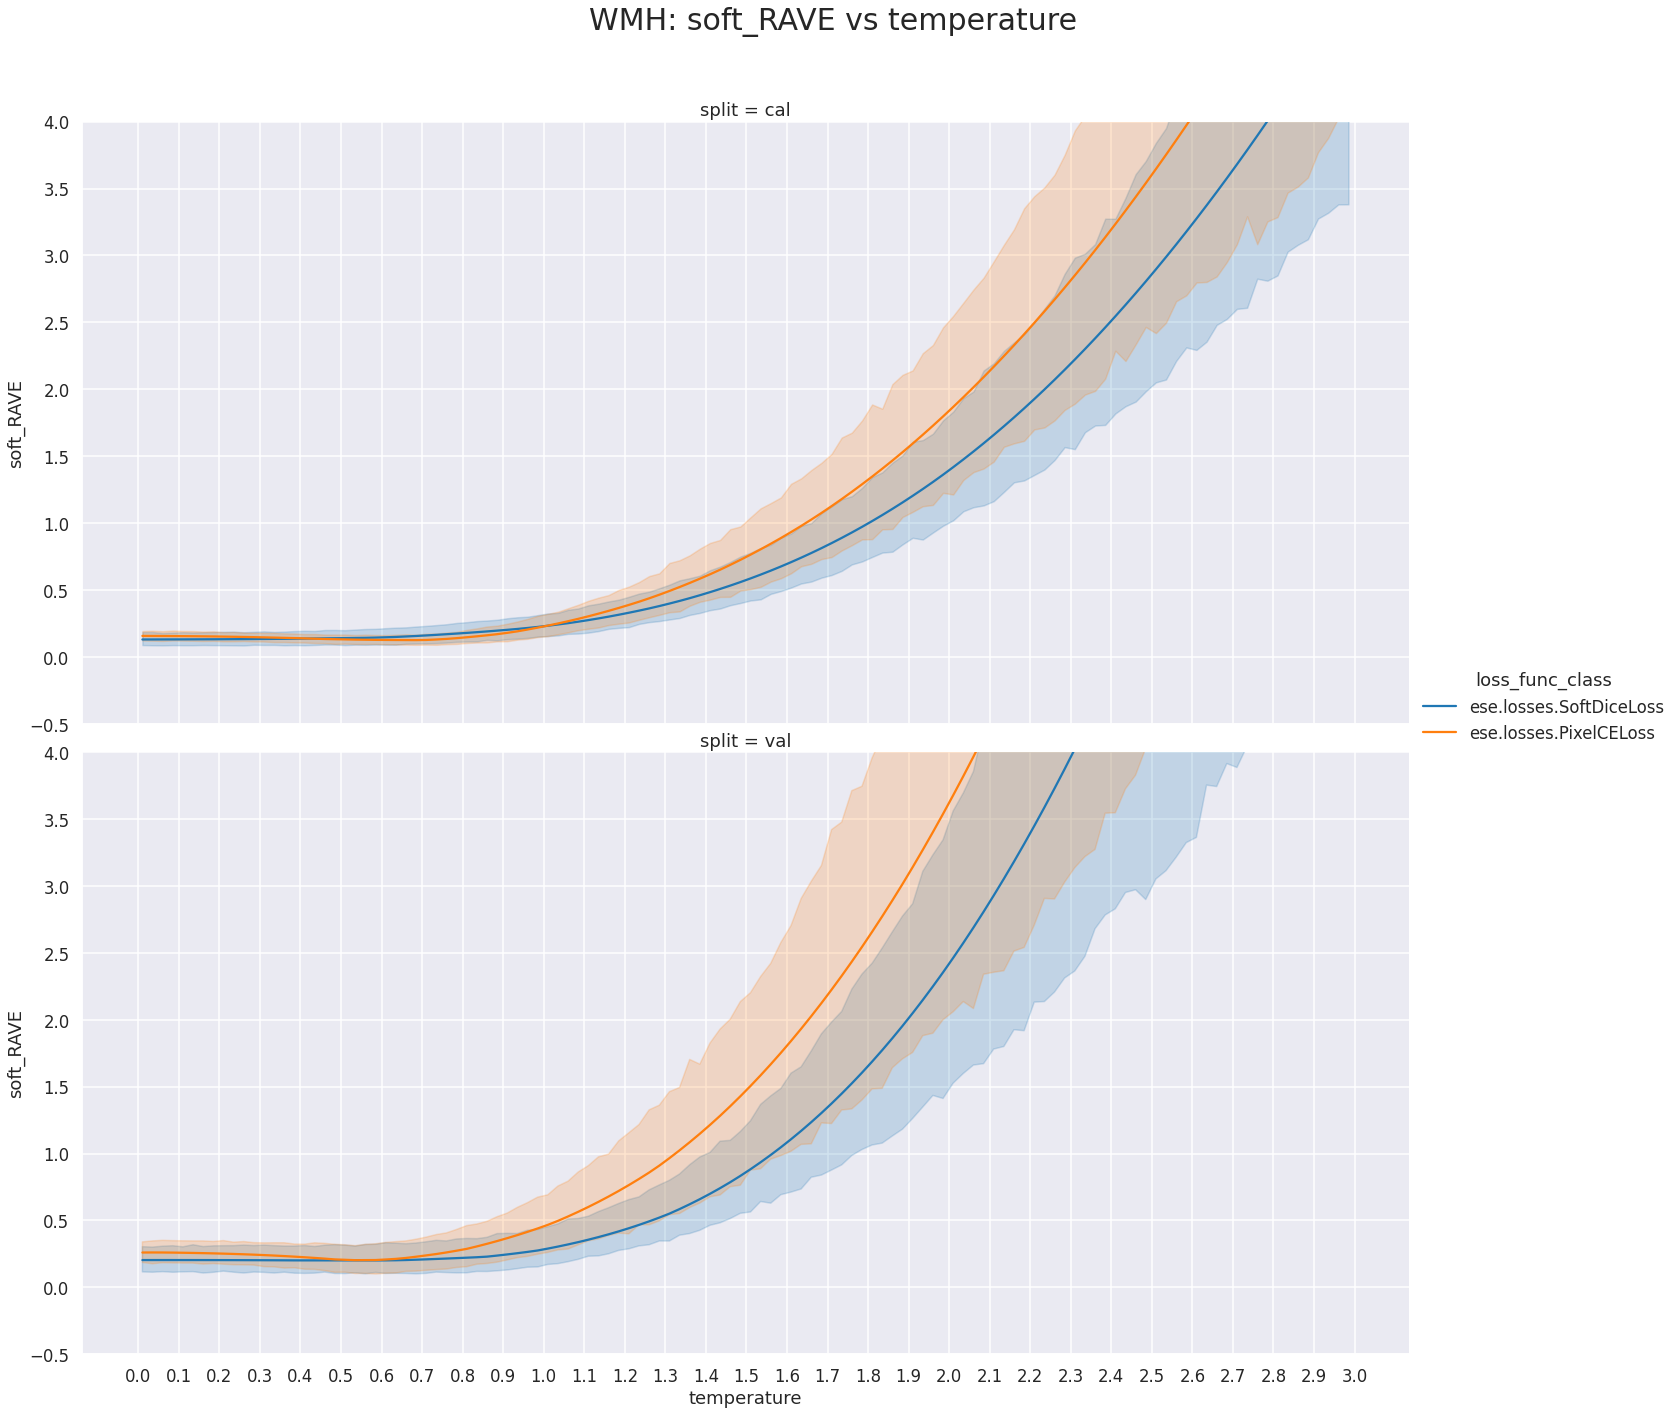

In [9]:
plt.figure(figsize=(30, 20))
# We want to plot the mean error vs temperature
g = sns.relplot(
    data=exp_df,
    x=x_key,
    y=y_key,
    hue='loss_func_class',
    row='split',
    kind='line',
    height=10,
    aspect=aspect,
    legend=(x_key == 'temperature')
)

g.set(xticks=xtick_range, ylim=y_lims)
# Make a global title using suptitle with some spacing
plt.suptitle(f'{exp_df["dataset"].unique()[0]}: {y_key} vs {x_key}', fontsize=30)
# Add spacing between the title and the plot
plt.subplots_adjust(top=0.9)

In [10]:
get_global_optimal_parameter(
    exp_df, 
    sweep_key=x_key, 
    y_key=y_key,
    group_keys=['split', 'loss_func_class']
).sort_values(y_key)

,split,loss_func_class,temperature,soft_RAVE
0,cal,ese.losses.PixelCELoss,0.685,0.125579
1,cal,ese.losses.SoftDiceLoss,0.010,0.130447
3,val,ese.losses.SoftDiceLoss,0.585,0.201360
2,val,ese.losses.PixelCELoss,0.535,0.203335


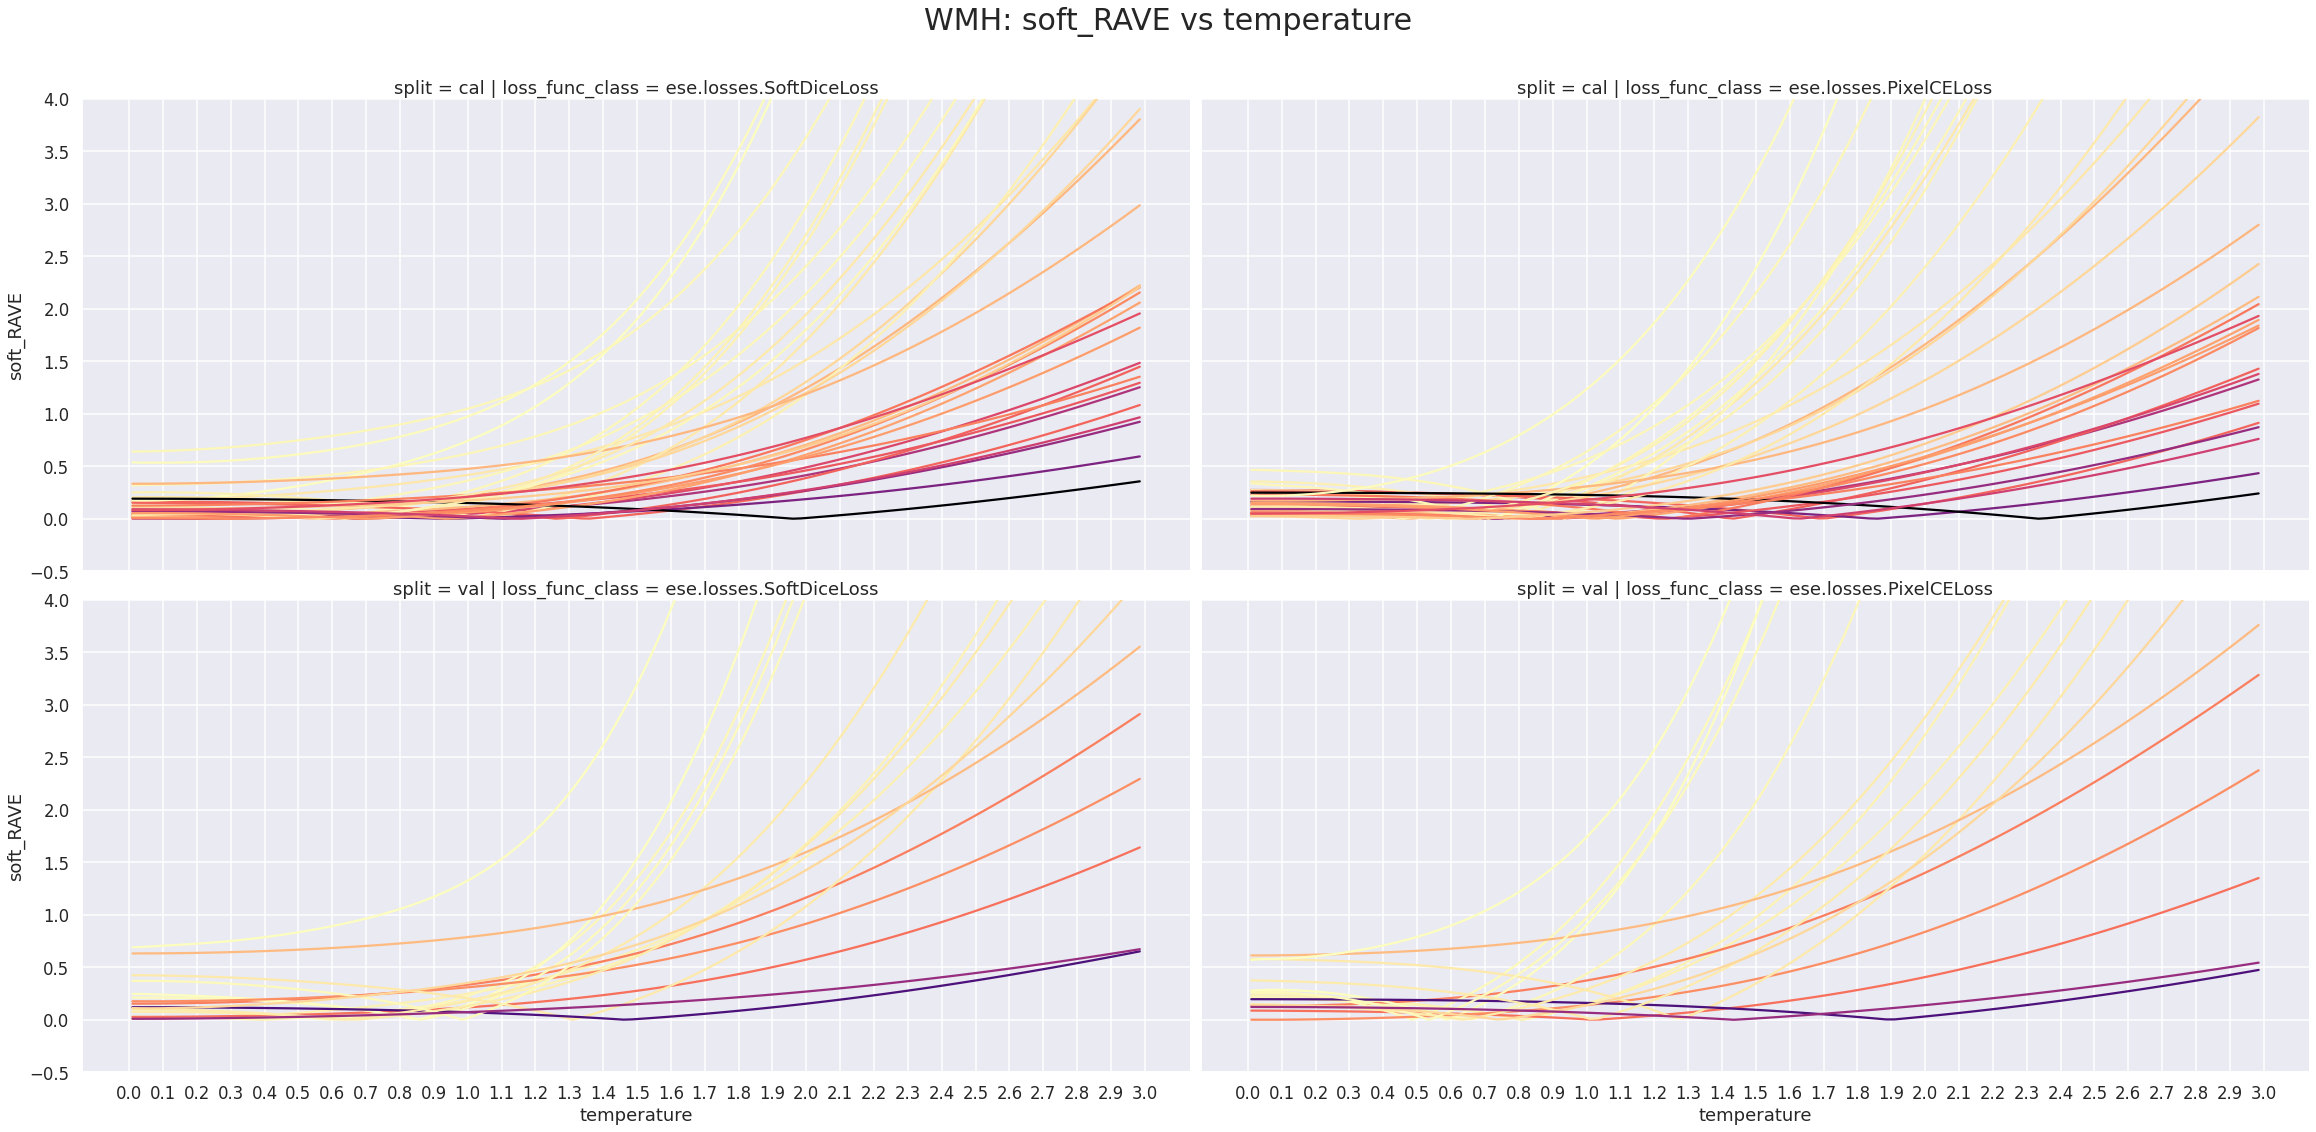

In [11]:
# We want to plot the mean error vs temperature
g = sns.relplot(
    data=exp_df,
    x=x_key,
    y=y_key,
    hue='data_id',
    col='loss_func_class',
    row='split',
    # col='split',
    kind='line',
    height=8,
    aspect=aspect,
    legend=False,
    palette=get_prop_color_palette(
                exp_df, 
                hue_key='data_id', 
                magnitude_key='gt_volume',
                cmap=cmap
            )
)

g.set(xticks=xtick_range, ylim=y_lims)
# Make a global title using suptitle with some spacing
plt.suptitle(f'{exp_df["dataset"].unique()[0]}: {y_key} vs {x_key}', fontsize=30)
# Add spacing between the title and the plot
plt.subplots_adjust(top=0.9)

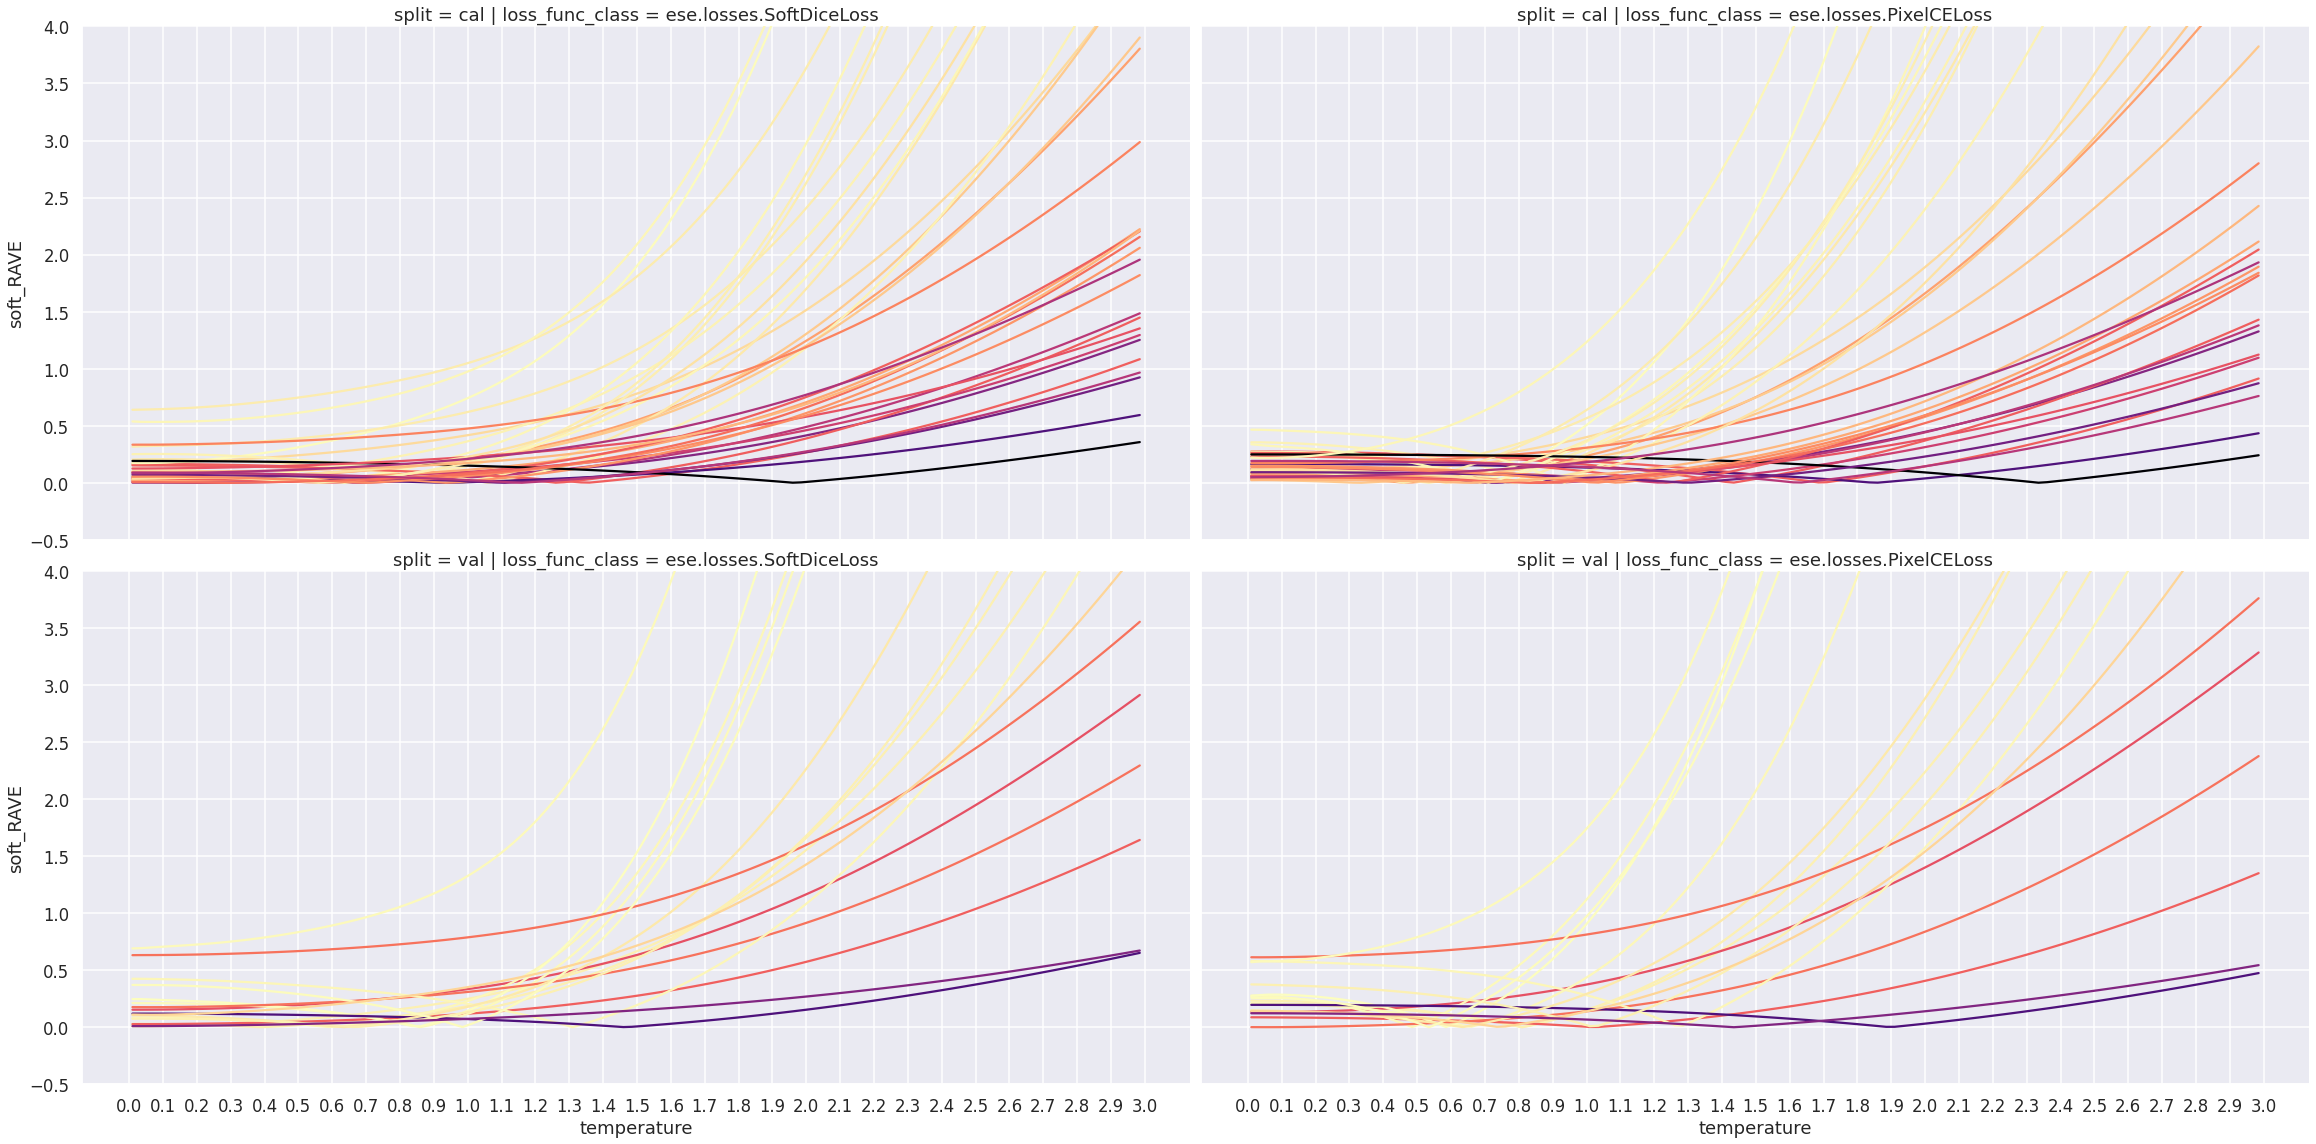

In [12]:
# We want to plot the mean error vs temperature
g = sns.relplot(
    data=exp_df,
    x=x_key,
    y=y_key,
    hue='data_id',
    col='loss_func_class',
    row='split',
    # col='split',
    kind='line',
    height=8,
    aspect=aspect,
    legend=False,
    palette=get_prop_color_palette(
                exp_df, 
                hue_key='data_id', 
                magnitude_key=('soft_volume' if x_key == 'threshold' else 'hard_volume'),
                cmap=cmap
            )
)

g.set(xticks=xtick_range, ylim=y_lims)

In [13]:
get_per_subject_optimal_values(
    exp_df, 
    sweep_key=x_key, 
    y_key=y_key,
    group_keys=['split', 'loss_func_class']
)

,split,loss_func_class,soft_RAVE
0,cal,ese.losses.PixelCELoss,0.020883
1,cal,ese.losses.SoftDiceLoss,0.079006
2,val,ese.losses.PixelCELoss,0.080214
3,val,ese.losses.SoftDiceLoss,0.107493
